## Risk Classification for Firms Utilizing Historical Audit Risk Scores and Discrepancies using KNN Classification

### Group 28 Members: Michael Ly, Avery Ma and Veer Arora

## Introduction

For businesses around the world, there exists a risk of the business working against the best interest of their stakeholders by misrepresenting financial information due to lack of financial controls or auditing procedures. The practice of auditing businesses requires extensive analysis and thorough investigation by accounting and auditing firms. Because there are so many businesses, there are not always enough resources to determine what business would make an appropriate target for an auditing firm to audit.

Our hope is that we can create a classification model that can help auditing firms determine what business would be considered a risk to financial mismanagement and classify them accordingly as targets of future audits.

Given a data set of characteristics of firms of different sectors, historical misstatement scores, and different risk scores would we be able to create a K - Nearest Neighbor classification model that can accurately identify risk firms? And will it be reliable and accurate enough for us to classify whether a firm is a Risk firm or a Non-Risk firm working in the best interest of its stakeholders?

The data set is a collection of firms that have been evaluated and scored based on the audit risk model which is a framework used for evaluating businesses based on audit risk, inherent risk, detection risk, and control risk factors (Hooda et al., 2018, Chang et al., 2008). Audit risk refers to the risk that the financial statements of the firm could not reveal any misstatements after considering internal control activities and audit detection (Chang et al., 2008). Inherent risk is a score dependent on factors such as a firm's risk for financial statement errors or fraudulence and account misstatements (Chang et al., 2008). Control risk is a score evaluating several internal control factors such as "control activity" looking at a firm's ability to have internal controls over data, accounting records, assets and duty division of internal auditing department (Chang et al., 2008).


Our data set examines the present and historical risk factors and financial discrepancy scores for the determining audit risk and concludes whether the firm is classified under Risk (1) or No Risk (0) (Hooda et al., 2018).

Our data set is drawn from the UCI Machine Learning Repository, with its origins from Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. https://archive.ics.uci.edu/ml/datasets/Audit+Data


We will be using Total, Money Value, Inherent Risk, and Audit Risk as predictors for our KNN classification model that will determine whether an observation is labeled as a Risk firm or a non-Risk firm (Hooda et al., 2018). 

There are many different variables described in the original audit risk dataset such as analysis scores completed by the original authors that we have decided to remove because they have not been defined or are only applicable to the study specific to the original authors. 

The original description of the data set reports that after an in-depth interview with auditors, important risk factors have been evaluated and probability of existence of these risk factors have been calculated using their present and past records.

We have performed exploratory analysis to determine the best predictors to train our KNN classification model.

Variables we will use as predictors for our classification model based on exploratory analysis:
* Total: Total amount of discrepancy found in auditing reports (PARA_A + PARA_B)
* Money Value: Amount of money involved in misstatements in the past audits
* Inherent Risk: The risk score posed by an error or omission in a financial statement due to a factor other than a failure of internal control
* Audit Risk: Refers to the risk that the financial statements could not find misstatement or fraudulence after their internal control activities and audit personnel’s detection

Label we will use for classification:
* Risk: Label used to classify whether a firm is considered Risk (1) or No Risk (2)

Variables from data set that will not be used as determined by exploratory analysis:
* Para A value: Discrepancy found in the planned-expenditure of inspection
* Para B value: Discrepancy found in the unplanned-expenditure of inspection
* Numbers: Historical discrepancy score.
* District Loss: Score based on amount of loss suffered by the district
* History: Average historical loss suffered by firm in the last 10 years.
* Control Risk: The chance of a material misstatement in a company’s financial statements because there aren’t any relevant internal controls to mitigate a particular risk or the internal controls in place malfunctioned.
* Detection Risk: The chance that an auditor will fail to find material misstatements that exist in an entity's financial statements.



In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [ ]:
set.seed(2022)
audit_risk_data <- read_csv("https://raw.githubusercontent.com/DicedOnion/dsci-100-2022w1-group-28/main/data/audit_risk.csv")
audit_risk_data <- mutate(audit_risk_data, Risk = as_factor(Risk))

audit_split <- initial_split(audit_risk_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


* We will be working with Risk as our factor so we convert it accordingly before we split our data set.
* We will be training a KNN classification model to predict whether a new observation will be labeled as a risk firm (1) or a non-risk firm (0).
* The data set is first split into training and testing data sets where 75% will be allocated to the training set and the 25% remaining will be used for testing the accuracy of our model.

In [ ]:
num_obs <- nrow(audit_training)
audit_training |> 
    group_by(Risk) |> 
    summarize(
        count = n(),
        percentage = n()/num_obs * 100)

Risk,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


* We then examine the number and percentage between the different levels of our factor within our training data set to see if each class is reasonably represented. We conclude that each class is reasonably represented in our training data set.

Warning message:
“Removed 62 rows containing non-finite values (stat_boxplot).”


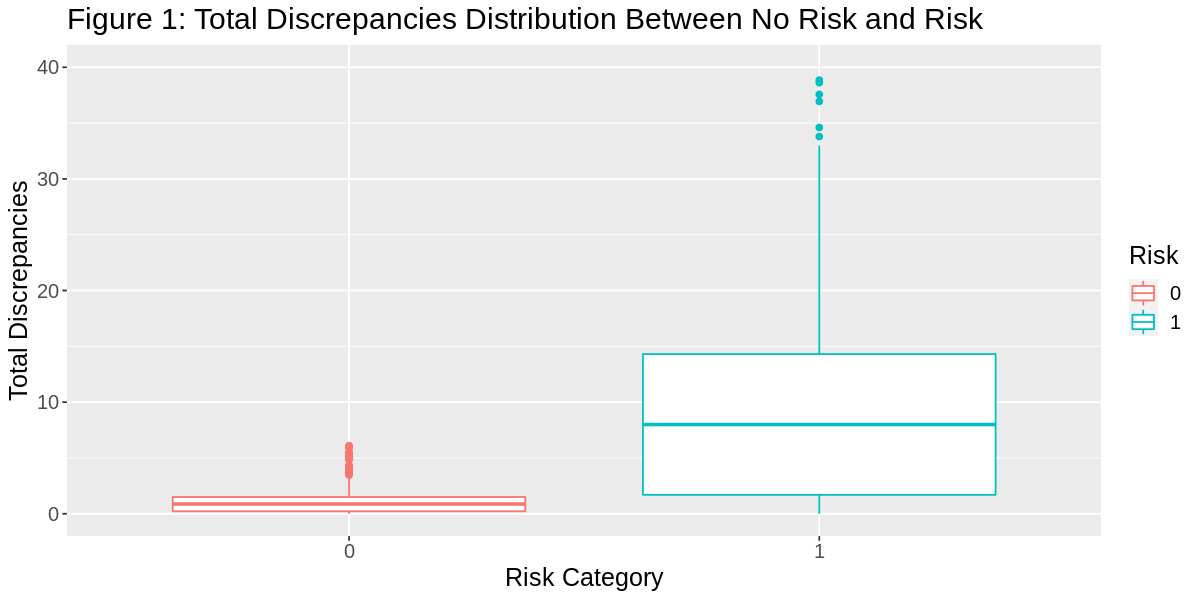

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(audit_training, aes(x = Risk, y=TOTAL, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Total Discrepancies") +
  ggtitle("Figure 1: Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of total discrepancies (combination of discrepancies found in planned and unplanned reports) between Risk and No Risk. When comparing the total discrepancies across both groups we can see that there is a clear difference between them. There appears to be greater total discrepancies found in the Risk class than that found in the No Risk class as represented by the higher median in the Risk box plot and the non-overlapping interquartile ranges. We can consider using this as a predictor for our model given that it shows this difference.

Warning message:
“Removed 24 rows containing non-finite values (stat_boxplot).”


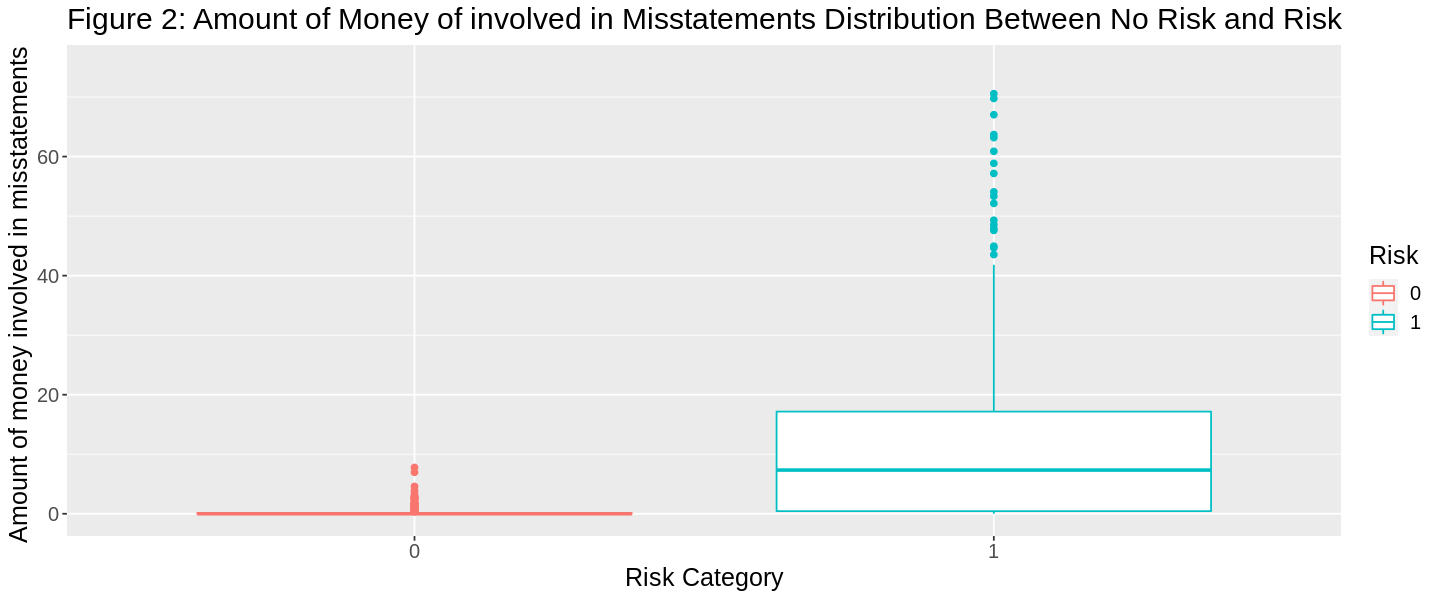

In [19]:
options(repr.plot.width = 12, repr.plot.height = 5)
ggplot(audit_training, aes(x = Risk, y=Money_Value, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 75)) +
  labs(x = "Risk Category", y = "Amount of money involved in misstatements ") +
  ggtitle("Figure 2: Amount of Money of involved in Misstatements Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of money involved in misstatements between Risk and No Risk. It is clear that the Risk group has a higher amount of money involved in misstatements than the No Risk group as represented by the median of both box plots. This is a predictor we can consider using for our model given this difference.

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”


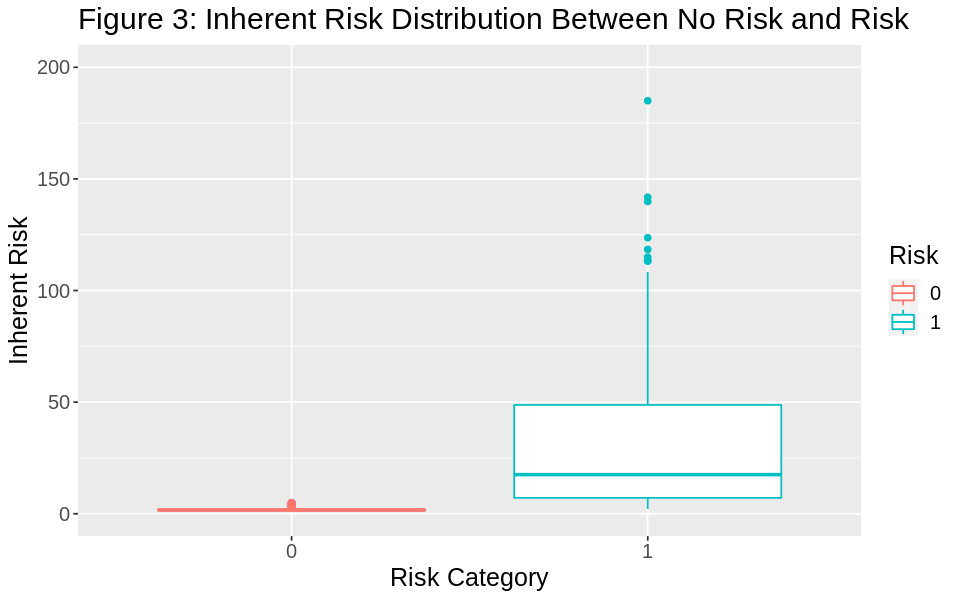

In [22]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training, aes(x = Risk, y=Inherent_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 200)) +
  labs(x = "Risk Category", y = "Inherent Risk") +
  ggtitle("Figure 3: Inherent Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* We used a box plot to represent the distribution of inherent risk across both Risk classes. Inherent risk is defined as the risk posed by an error or omission in a financial statement due to a factor other than a failure of internal control. We can evidently see that firms that are classified as Risk have a far greater inherent risk score than firms with no risk according to our boxplot comparing the distribution of the two classes. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make inherent risk a good reliable predictor for our model.

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


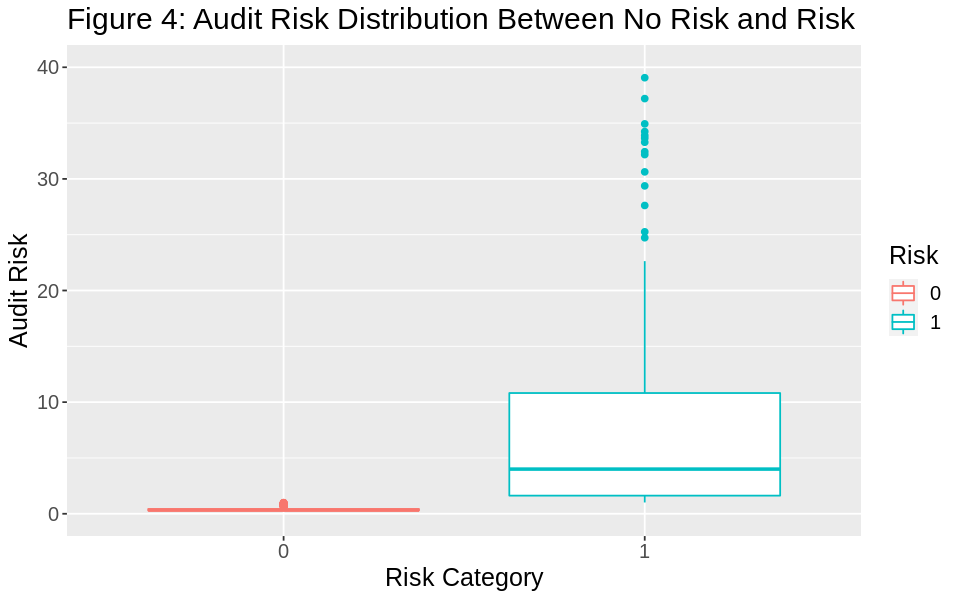

In [20]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training, aes(x = Risk, y=Audit_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Audit Risk") +
  ggtitle("Figure 4: Audit Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* We use a box plot to represent the distribution of Audit Risk across our two classes. In general, audit risk is defined as the risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated. Looking at the box plot distributions we can see that Risk class firms have a significantly higher distribution of audit risk score than No Risk firms. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make audit risk a good reliable predictor to utilize in our classification model.

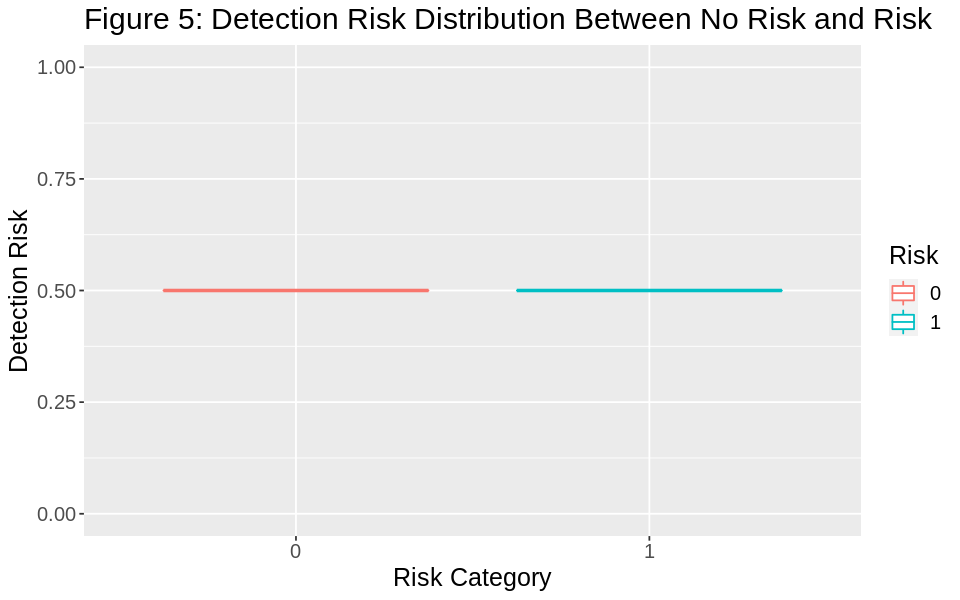

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training, aes(x = Risk, y=Detection_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 1)) +
  labs(x = "Risk Category", y = "Detection Risk") +
  ggtitle("Figure 5: Detection Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of detection risk between Risk and No Risk. Detection risk is defined as the chance that an auditor will fail to find material misstatements that exist in an entity's financial statements. Comparing both box plots, we can see that detection risk does not appear to be different across the two risk categories. This would not make detection risk a good predictor for our model.

Warning message:
“Removed 45 rows containing missing values (geom_point).”


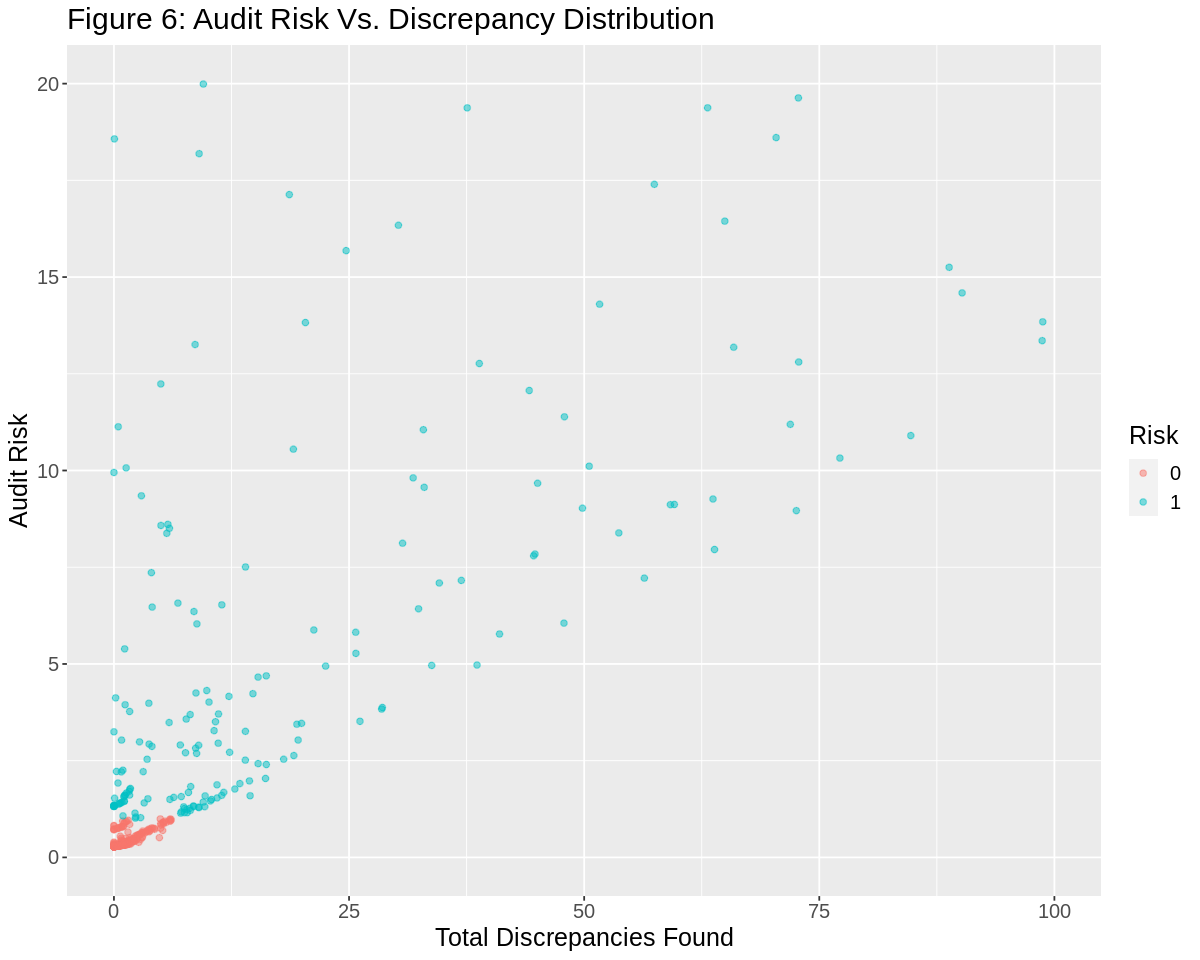

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8)

discrepancy_plot <- audit_training |>
ggplot(aes(x = TOTAL, y = Audit_Risk, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Total Discrepancies Found") +
    ylab("Audit Risk") +
    labs(color = "Risk") +
    ggtitle("Figure 6: Audit Risk Vs. Discrepancy Distribution") +
    theme(text = element_text(size = 15))+
    ylim(c(0, 20)) +
    xlim(c(0,100))


discrepancy_plot

* This scatter plot is to determine whether there is any relationship between Total Number of Discrepancies found and Audit Risk Score. We see that there is a clustering of No Risk near the lower left with Risk observations scattered above and to the right of the plot. Another observation is as total amount of discrepancies increase the audit risk score also increases as well. This shows that No Risk observations tend to have lower audit risk scores and lower total discrepancies.

In [ ]:
audit_training_select <- audit_training |> 
    select(TOTAL, Money_Value, Inherent_Risk, Audit_Risk, Risk) |>
    drop_na()
audit_training_select

TOTAL,Money_Value,Inherent_Risk,Audit_Risk,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4.83,0.94,2.554,0.5108,0
0.08,0.00,1.416,0.2832,0
0.83,2.95,2.156,0.4312,0
⋮,⋮,⋮,⋮,⋮
0.00,0.00,2.20,1.320,1
1.69,0.90,2.93,1.758,1
8.49,0.43,6.58,1.316,1


* The exploratory analysis on the variables in our data set helped us determine 4 predictors that we will be using to train our training data. We determined that the variables Total Discrepancies, Money Value, Inherent Risk and Audit Risk will be suitable predictors according to the differences in distributions found between the risk and non-risk labels during exploratory analysis.

In [ ]:
knn_spec <- nearest_neighbor(weight_func ="rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_audit_recipe <- recipe(Risk ~. , data = audit_training_select) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

audit_vfold <- vfold_cv(audit_training_select, v = 5, strata = Risk)


gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

audit_results <- workflow() |>
    add_recipe(knn_audit_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = audit_vfold, grid = gridvals) |>
    collect_metrics()

accuracies <- audit_results |>
    filter(.metric == "accuracy") 

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9948421,5,0.003426357,Preprocessor1_Model01
6,accuracy,binary,0.9896991,5,0.004182727,Preprocessor1_Model02
11,accuracy,binary,0.9827426,5,0.005482633,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.9017480,5,0.01377864,Preprocessor1_Model18
91,accuracy,binary,0.9000386,5,0.01321147,Preprocessor1_Model19
96,accuracy,binary,0.9000386,5,0.01321147,Preprocessor1_Model20


* After determining our four predictors, we then select them to train our model.
* The predictors are then preprocessed through scaling and centering with the recipe function to ensure all predictors have equal influence over the assignment of the label for classification.
* The KNN specifications are first set to tune our classifier using five-fold cross-validation on our training data to find the most optimal $k$ to train our model.
* A workflow function is then applied to the recipe and KNN specifications created
* A data frame is created with a sequence of values of $k$ from 1 to 15 to try.
* This data frame is passed to the tune_grid function within the workflow function
* The collect_metrics function is then applied to generate the the predicted accuracy mean values for each value of $k$

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.01206897
Best kernel: rectangular
Best k: 2

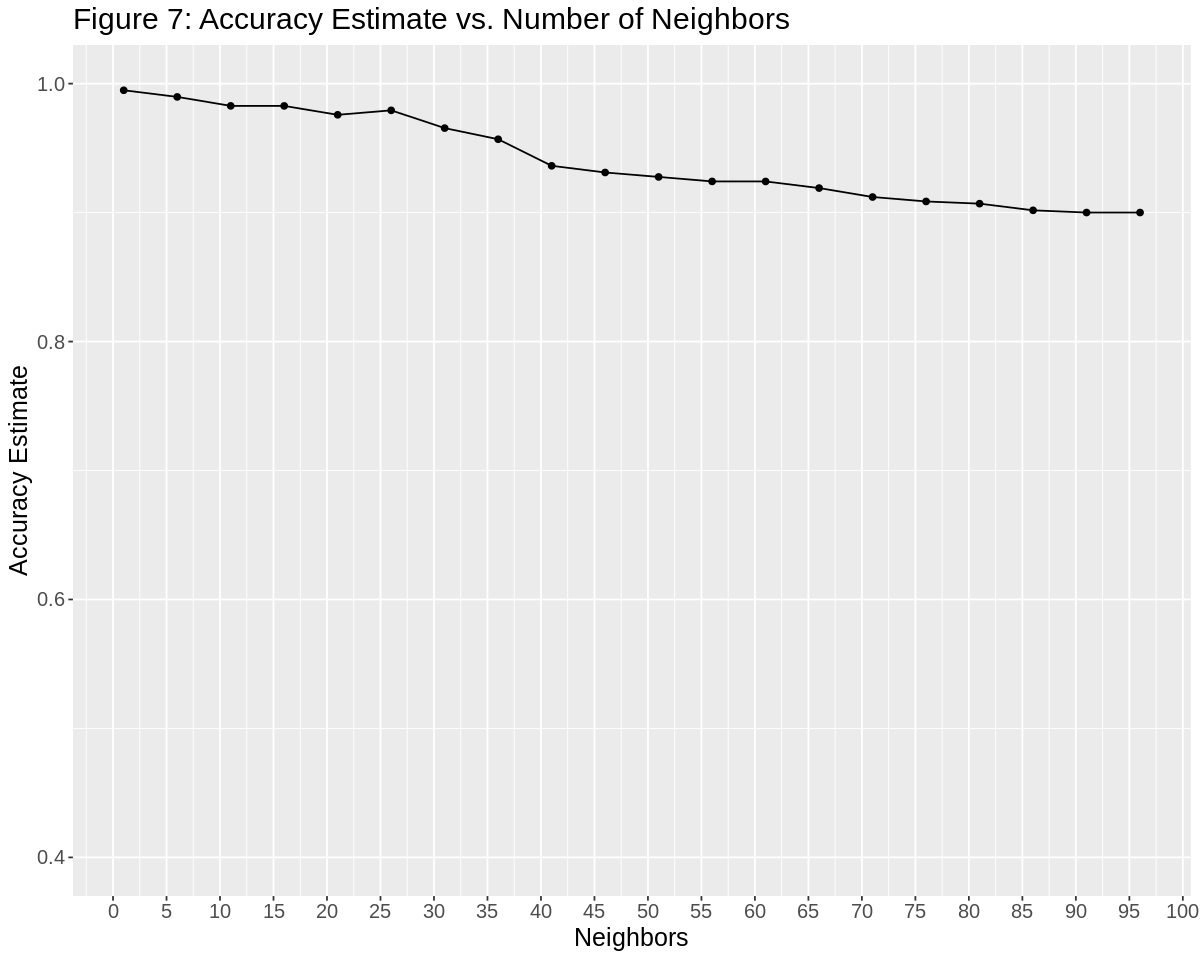

In [29]:
options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        scale_x_continuous(breaks = seq(0, 100, by = 5)) +  
        scale_y_continuous(limits = c(0.4, 1.0)) +
        theme(text = element_text(size = 15)) +
        ggtitle("Figure 7: Accuracy Estimate vs. Number of Neighbors")

cross_val_plot

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_audit_fit <- workflow() |>
    add_recipe(knn_audit_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = audit_training_select)

knn_audit_fit

* We determined that our best $k$ value is 2 according to our cross-validation plot. Then used the $k$ value of 2 for our KNN specifications to train our KNN classification model.
* Then we applied the model to our testing data and generated an accuracy estimate and confusion matrix to assess the accuracy of our model.

In [ ]:
audit_predictions <- predict(knn_audit_fit, audit_testing) |>
    bind_cols(audit_testing)

audit_metrics <- audit_predictions |> 
    metrics(truth = Risk, estimate = .pred_class)
audit_metrics

audit_conf_mat <- audit_predictions |> 
    conf_mat(truth = Risk, estimate = .pred_class)
audit_conf_mat

New names:
• `Score_B...7` -> `Score_B...8`
• `Score_B...11` -> `Score_B...12`


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9897436
kap,binary,0.9786348


          Truth
Prediction   0   1
         0 116   0
         1   2  77

## Discussion

* The accuracy estimate result is 98.97% when validating our model against our testing data. This suggests that our classification model appears to reliably predict whether a firm is a Risk firm or a No Risk Firm validated using our testing data. It was unexpected that our KNN classification model would be able to achieve such a high accuracy estimate. The confusion matrix shows that our model was able to correctly predict 116 firms label of risk 0 and 77 firms  of label risk 1, where only 2 firms that had labels of risk 0 being incorrectly classified as risk 1. This shows that our classifier is capable of producing false positive results, which can be important when considering the model's application in the context of classifying certain firms for audit.

* The high accuracy rate may suggest that our data set is small enough for our model to reliably predict whether a firm is a Risk or No Risk firm. Despite being able to produce a high accuracy estimate, our model may not be able to achieve similar results across larger data sets without further investigation. As a result, this model will have to be further validated using larger data sets to assess its reliability, accuracy and robustness. 

* If a general classification model can be established, then it would allow for audit firms or governments to quickly utilize the model to allow for appropriate and productive labeling of specific businesses or firms that have a high risk for financial mismanagement or fraud. Therefore, this would allow these firms to be more effective and efficient in identifying and preventing fraudulent business practices by leveraging data produced by the traditional audit risk model. (Chang et al., 2008)

* Since there can be many other indicators of financial fraud and risk used in business auditing practices, what other predictors can be used to create an even better model for classifying whether a firm should be considered a target for audit? And can it be generalized to different business areas in different parts of the world with different audit accounting practices?

Citations: 
1. Hooda, Nishtha & Bawa, Seema & Rana, Prashant. (2018). 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32. 10.1080/08839514.2018.1451032.  UCI Machine Learning Repository: Audit Data Data Set. Retrieved December 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Audit+Data 
3. She-I Chang, Chih-Fong Tsai, Dong-Her Shih, Chia-Ling Hwang,
The development of audit detection risk assessment system: Using the fuzzy theory and audit risk model, Expert Systems with Applications, Volume 35, Issue 3, 2008, Pages 1053-1067,
ISSN 0957-4174,https://doi.org/10.1016/j.eswa.2007.08.057. (https://www.sciencedirect.com/science/article/pii/S0957417407003235)